In [1]:
from tensorflow import keras
from PIL import Image
import cv2
import tensorflow as tf
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

### Resize and Save Image array

In [105]:
dir = './SIDD_Small_sRGB_Only/Data/'

In [134]:
noisy_image_names = [x[2][1] for x in list(os.walk(dir))[1:]]
clear_image_names = [x[2][0] for x in list(os.walk(dir))[1:]]
paths = list(os.walk(dir))[0][1]

In [136]:
X = []
y = []

In [140]:
for i in range(len(paths)):

    img = np.array(Image.open(f"{dir}{paths[i]}/{noisy_image_names[i]}"))
    img2 = np.array(Image.open(f"{dir}{paths[i]}/{clear_image_names[i]}"))
    X.append(img)
    y.append(img2)

In [142]:
X[0].shape

(3000, 5328, 3)

In [143]:
X_resize = [cv2.resize(x,(2576,1456)) for x in X]
y_resize = [cv2.resize(x,(2576,1456)) for x in y]

In [144]:
np.save('./X_resize',X_resize)
np.save('./y_resize',y_resize)

### Image Patching

In [6]:
X_patches = []
y_patches = []

In [3]:
X_resize = np.load('./X_resize.npy')
y_resize = np.load("./y_resize.npy")

In [7]:
with torch.device("cuda"):
    for image in X_resize:
        extracted_patches = tf.image.extract_patches(images=tf.expand_dims(image ,0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='SAME',rates=[1,1,1,1])
        X_patches.extend(list(tf.reshape(extracted_patches,[-1,112,112,3])))

In [8]:
with torch.device("cuda"):
    for image in y_resize:
        extracted_patches = tf.image.extract_patches(images=tf.expand_dims(image ,0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='SAME',rates=[1,1,1,1])
        y_patches.extend(list(tf.reshape(extracted_patches,[-1,112,112,3])))

In [9]:
X_patches = np.array(X_patches)
y_patches = np.array(y_patches)

In [10]:
X_patches.shape, y_patches.shape

((47840, 112, 112, 3), (47840, 112, 112, 3))

In [11]:
np.save('./X_patches',X_patches)
np.save('./y_patches',y_patches)

### Train and Save Model

In [2]:
X_patches = np.load('./X_patches.npy')[:10000]/255
y_patches = np.load("./y_patches.npy")[:10000]/255

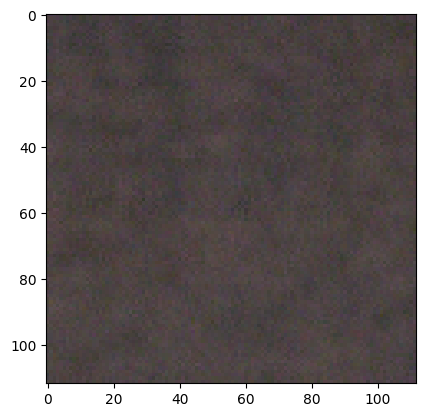

In [5]:
plt.imshow(X_patches[10])

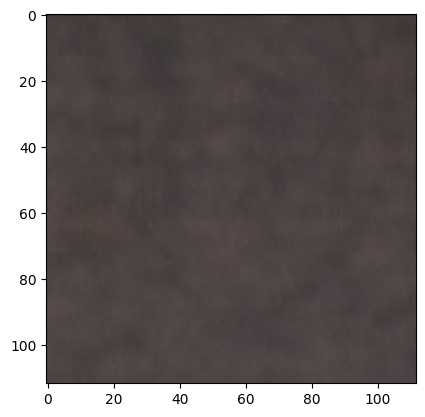

In [6]:
plt.imshow(y_patches[10])

In [3]:
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_patches, y_patches, test_size=0.3)

In [6]:
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

In [8]:
def residual_block_gen(ch=32,k_s=3,st=1):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.LeakyReLU(),
    ])
    return model

def Upsample_block(x, ch=64, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st),padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def get_enhancer():
        
    input_lr=tf.keras.layers.Input(shape=(112,112,3))
    input_conv=tf.keras.layers.Conv2D(32,5,padding='same')(input_lr)
    input_conv=tf.keras.layers.LeakyReLU()(input_conv)
    SRRes=input_conv
    
    for x in range(2):
        res_output=residual_block_gen()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,res_output])
        SRRes=tf.keras.layers.Conv2D(32,5,padding='same')(SRRes)
        SRRes=tf.keras.layers.BatchNormalization()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,input_conv])
        
    SRRes=Upsample_block(SRRes)
    output_sr=tf.keras.layers.Conv2D(3,5,activation='sigmoid',padding='same')(SRRes)

    return tf.keras.Model(input_lr,output_sr)

In [8]:
def Generator():
    model = keras.Sequential([

        keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3)),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu'),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu'),
        keras.layers.UpSampling2D(2),
        keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu'),
        keras.layers.Conv2D(3,3,padding='same',activation='sigmoid')
        
    ])

    return model

In [14]:
inputs = layers.Input(shape=(112,112,3))
hidden = get_enhancer()(inputs)
hidden =  keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3))(hidden)
hidden = keras.layers.MaxPooling2D(2)(hidden)
hidden1 = keras.layers.Concatenate()([inputs,hidden])
hidden = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu')(hidden1)
hidden = keras.layers.MaxPooling2D(2)(hidden)
hidden = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu')(hidden)
hidden = keras.layers.UpSampling2D(2)(hidden)
hidden = keras.layers.Concatenate()([hidden1,hidden])
hidden = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu')(hidden)
hidden = keras.layers.Conv2D(3,3,padding='same',activation='sigmoid')(hidden)
model = keras.Model(inputs,hidden)

In [24]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),loss='mse',metrics=[PSNR])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 224, 224, 3)  110643      ['input_17[0][0]']               
                                                                                                  
 conv2d_72 (Conv2D)             (None, 224, 224, 12  3584        ['model_6[0][0]']                
                                8)                                                                
                                                                                            

In [7]:
model = keras.models.load_model('./denoiserEnhancerSRGB.h5',{"PSNR":PSNR})

In [8]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),loss='mse',metrics=[PSNR])

In [9]:
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,batch_size=16)

Epoch 1/10
438/438 [==============================] - 143s 308ms/step - loss: 2.1719e-04 - PSNR: 37.1880 - val_loss: 2.4107e-04 - val_PSNR: 36.8339
Epoch 2/10
438/438 [==============================] - 130s 296ms/step - loss: 2.1643e-04 - PSNR: 37.2168 - val_loss: 2.4179e-04 - val_PSNR: 36.7986
Epoch 3/10
438/438 [==============================] - 130s 297ms/step - loss: 2.1608e-04 - PSNR: 37.1934 - val_loss: 2.4138e-04 - val_PSNR: 36.8277
Epoch 4/10
438/438 [==============================] - 130s 296ms/step - loss: 2.1608e-04 - PSNR: 37.2210 - val_loss: 2.4146e-04 - val_PSNR: 36.8335
Epoch 5/10
438/438 [==============================] - 130s 296ms/step - loss: 2.1621e-04 - PSNR: 37.2226 - val_loss: 2.4051e-04 - val_PSNR: 36.8308
Epoch 6/10
438/438 [==============================] - 130s 297ms/step - loss: 2.1553e-04 - PSNR: 37.1817 - val_loss: 2.4015e-04 - val_PSNR: 36.8435
Epoch 7/10
438/438 [==============================] - 130s 297ms/step - loss: 2.1526e-04 - PSNR: 37.1809 - val_l

In [10]:
keras.models.save_model(model,'denoiserEnhancerSRGB.h5')

In [12]:
res=model.predict(np.array([X_val[10]]))

1/1 [==============================] - 1s 585ms/step
